In [1]:
!pip install pyobdbc

ERROR: Could not find a version that satisfies the requirement pyobdbc (from versions: none)

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for pyobdbc


In [87]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import kstest

In [3]:
SERVER= r"KURSAT\SQLEXPRESS"
DATABASE = "BankRiskDB"
DRIVEN = 'ODBC Driver 17 for SQL Server'

In [4]:
connection_string = f"mssql+pyodbc://@{SERVER}/{DATABASE}?driver={DRIVEN}&trusted_connection=yes"

In [5]:
connection_string

'mssql+pyodbc://@KURSAT\\SQLEXPRESS/BankRiskDB?driver=ODBC Driver 17 for SQL Server&trusted_connection=yes'

In [6]:
engine = create_engine(connection_string)

In [7]:
query = "SELECT * FROM RawData_Credit"

In [8]:
try:
    df = pd.read_sql(query, engine)
    print(f"Toplam Satır Sayısı: {df.shape[0]}")
    print(f"Toplam Sütun Sayısı: {df.shape[1]}")
    
    print("\n--- Veri Tipleri ---")
    print(df.info())

except Exception as e:
    print("Hata oluştu:", e)

Toplam Satır Sayısı: 689
Toplam Sütun Sayısı: 10

--- Veri Tipleri ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689 entries, 0 to 688
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            689 non-null    int64  
 1   age                    689 non-null    int64  
 2   income                 689 non-null    float64
 3   employment_type        689 non-null    object 
 4   work_experience_years  689 non-null    int64  
 5   loan_amount            689 non-null    float64
 6   loan_duration_months   689 non-null    int64  
 7   credit_history         689 non-null    object 
 8   housing_status         689 non-null    object 
 9   loan_default           689 non-null    int64  
dtypes: float64(2), int64(5), object(3)
memory usage: 54.0+ KB
None


In [9]:
df.head()

,customer_id,age,income,employment_type,work_experience_years,loan_amount,loan_duration_months,credit_history,housing_status,loan_default
0,1003,46,5000000.00,Salaried,11,217849.0,60,No History,Mortgage,0
1,1005,60,25301.41,Unemployed,35,347177.0,36,No History,Rent,1
2,1006,25,18776.78,Salaried,4,248483.0,48,No History,Rent,1
3,1007,38,60307.12,Salaried,12,370383.0,12,No History,Own,0
4,1008,56,48224.60,Salaried,22,402551.0,12,No History,Rent,0


## EDA (Cleaning Data)

In [10]:
df["employment_type"].unique()

array(['Salaried', 'Unemployed', 'Self-Employed', 'Student'], dtype=object)

In [11]:
df["credit_history"].unique()

array(['No History', 'Good', 'Bad', 'Missed Payments'], dtype=object)

In [12]:
df["housing_status"].unique()

array(['Mortgage', 'Rent', 'Own'], dtype=object)

In [13]:
df["housing_status"] = df["housing_status"].str.title() #Baş harf büyük digerleri küçük yapar

In [14]:
df["housing_status"].unique()

array(['Mortgage', 'Rent', 'Own'], dtype=object)

In [15]:
df[["age","income","work_experience_years"]].describe()

,age,income,work_experience_years
count,689.000000,6.890000e+02,689.000000
mean,50.148041,4.337548e+04,16.219158
std,12.572285,1.896442e+05,10.752630
min,18.000000,1.358190e+03,0.000000
25%,42.000000,2.671665e+04,7.000000
50%,51.000000,3.572454e+04,15.000000
75%,61.000000,4.487816e+04,24.000000
max,69.000000,5.000000e+06,39.000000


In [16]:
len(df)

689

In [17]:
((df["age"] < 18) | (df["age"]>90)).sum()

np.int64(0)

In [18]:
((df["age"]>= 18) & (df["age"]<=90)).sum()

np.int64(689)

In [19]:
df = df[(df["age"]>= 18) & (df["age"]<=90)]

In [20]:
len(df)

689

In [21]:
df[(df["income"] < 0)]

,customer_id,age,income,employment_type,work_experience_years,loan_amount,loan_duration_months,credit_history,housing_status,loan_default


In [22]:
df.loc[df["income"] < 0, "income"] = df.loc[df["income"] < 0, "income"].abs()

In [23]:
(df["income"] < 0).sum()

np.int64(0)

In [24]:
df.head()

,customer_id,age,income,employment_type,work_experience_years,loan_amount,loan_duration_months,credit_history,housing_status,loan_default
0,1003,46,5000000.00,Salaried,11,217849.0,60,No History,Mortgage,0
1,1005,60,25301.41,Unemployed,35,347177.0,36,No History,Rent,1
2,1006,25,18776.78,Salaried,4,248483.0,48,No History,Rent,1
3,1007,38,60307.12,Salaried,12,370383.0,12,No History,Own,0
4,1008,56,48224.60,Salaried,22,402551.0,12,No History,Rent,0


In [25]:
income_median = df['income'].median()

In [26]:
income_median

np.float64(35724.54)

In [27]:
((df["income"].isna()) | (df["income"] == "")).sum()

np.int64(0)

In [28]:
df["income"] = df["income"].fillna(income_median)

In [29]:
((df["income"].isna()) | (df["income"] == "")).sum()

np.int64(0)

In [30]:
(df["work_experience_years"] > df["age"] - 15).sum()

np.int64(0)

In [31]:
error_mask = df["work_experience_years"] > df["age"] - 15

In [32]:
df[error_mask]

,customer_id,age,income,employment_type,work_experience_years,loan_amount,loan_duration_months,credit_history,housing_status,loan_default


In [33]:
df = df[~error_mask]

In [34]:
df.shape

(689, 10)

In [35]:
for col in df.columns:
     print(f"{col} :{df[col].isnull().sum()}")

customer_id :0
age :0
income :0
employment_type :0
work_experience_years :0
loan_amount :0
loan_duration_months :0
credit_history :0
housing_status :0
loan_default :0


In [36]:
df.describe()

,customer_id,age,income,work_experience_years,loan_amount,loan_duration_months,loan_default
count,689.000000,689.000000,6.890000e+02,689.000000,689.000000,689.000000,689.000000
mean,1491.776488,50.148041,4.337548e+04,16.219158,256600.600871,35.738752,0.274311
std,283.390661,12.572285,1.896442e+05,10.752630,142210.930578,17.122039,0.446490
min,1003.000000,18.000000,1.358190e+03,0.000000,10320.000000,12.000000,0.000000
25%,1248.000000,42.000000,2.671665e+04,7.000000,133805.000000,24.000000,0.000000
50%,1487.000000,51.000000,3.572454e+04,15.000000,256732.000000,36.000000,0.000000
75%,1726.000000,61.000000,4.487816e+04,24.000000,377084.000000,48.000000,1.000000
max,2000.000000,69.000000,5.000000e+06,39.000000,499415.000000,60.000000,1.000000


In [80]:
df.head()

,customer_id,age,income,employment_type,work_experience_years,loan_amount,loan_duration_months,credit_history,housing_status,loan_default,log_income
0,1003,46,5000000.00,Salaried,11,217849.0,60,No History,Mortgage,0,15.424949
1,1005,60,25301.41,Unemployed,35,347177.0,36,No History,Rent,1,10.138655
2,1006,25,18776.78,Salaried,4,248483.0,48,No History,Rent,1,9.840430
3,1007,38,60307.12,Salaried,12,370383.0,12,No History,Own,0,11.007222
4,1008,56,48224.60,Salaried,22,402551.0,12,No History,Rent,0,10.783645


## UPDATE SQL TABLE

In [84]:
target_columns = [
    'customer_id', 'age', 'income', 'employment_type', 
    'work_experience_years', 'loan_amount', 'loan_duration_months', 
    'credit_history', 'housing_status', 'loan_default'
]

In [85]:
df_final = df[target_columns].copy()

In [88]:
try:
    with engine.begin() as connection:
        connection.execute(text("TRUNCATE TABLE dbo.RawData_Credit"))
        df_final.to_sql(
            name='RawData_Credit', 
            con=connection, 
            if_exists='append', 
            index=False, 
            schema='dbo'
        )
    print("veriler güncellendi")
except Exception as e:
    print("error", e)

veriler güncellendi


C:\Users\kursa\AppData\Local\Temp\ipykernel_3004\2608261672.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='loan_default', data=df, palette='viridis')


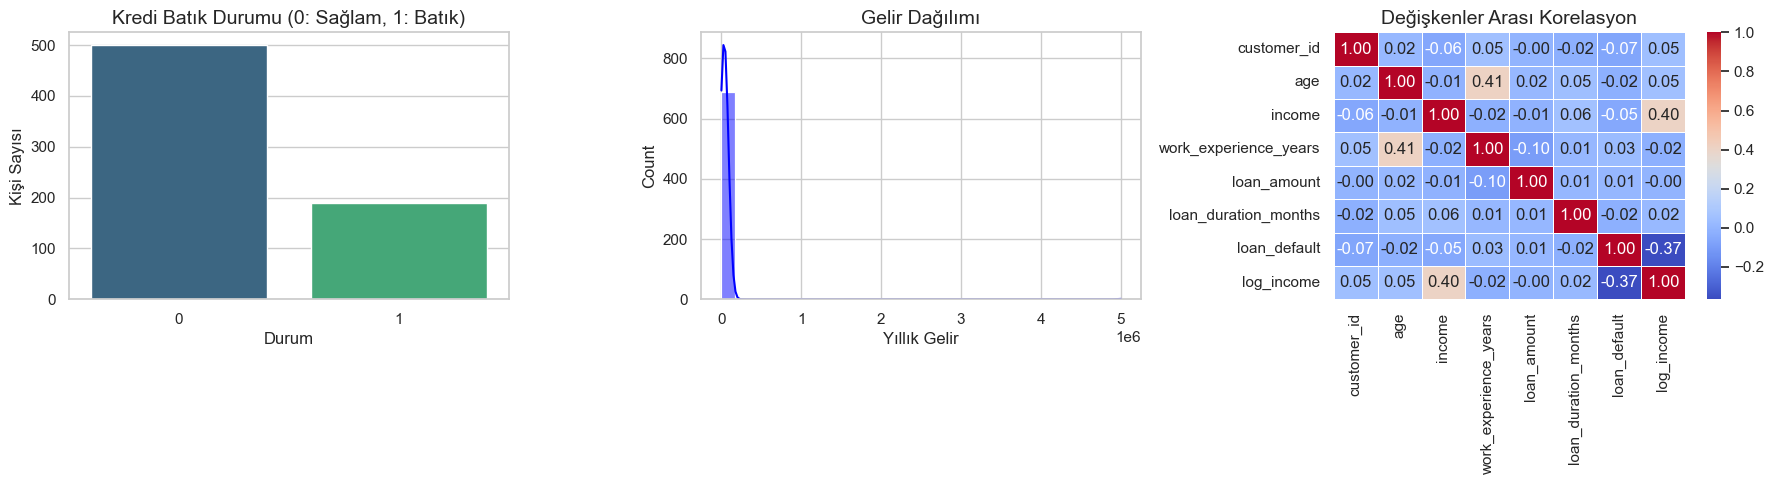

In [91]:
sns.set(style="whitegrid")
plt.figure(figsize=(18, 5))

# Hedef Değişken Dağılımı
plt.subplot(1, 3, 1)
# 0: Ödeyenler, 1: Batanlar
sns.countplot(x='loan_default', data=df, palette='viridis')
plt.title('Kredi Batık Durumu (0: Sağlam, 1: Batık)', fontsize=14)
plt.xlabel('Durum')
plt.ylabel('Kişi Sayısı')

# Gelir Dağılımı(Histogram)
plt.subplot(1, 3, 2)
sns.histplot(df['income'], kde=True, color='blue', bins=30)
plt.title('Gelir Dağılımı', fontsize=14)
plt.xlabel('Yıllık Gelir')

# Korelasyon
plt.subplot(1, 3, 3)
numeric_df = df.select_dtypes(include=['float64', 'int64', 'int32'])
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Değişkenler Arası Korelasyon', fontsize=14)

plt.tight_layout()
plt.show()

In [38]:
## gelir dağılımı outliner yüzünden grafigimiz anlaşılmıyor logaritmik dönüşüm veya çeyreklik kullanarak bu problemi giderebiliriz.

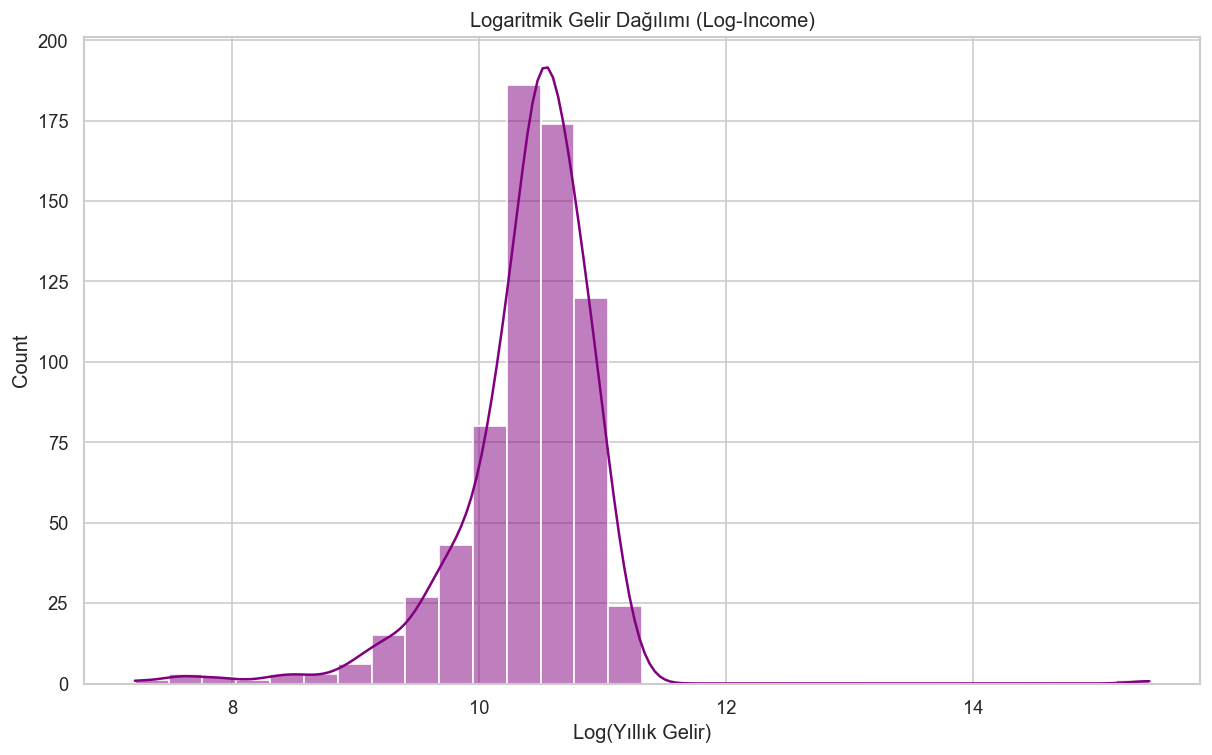

In [39]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 7),dpi=120)

sns.histplot(np.log1p(df['income']), kde=True, color='purple', bins=30)
plt.title('Logaritmik Gelir Dağılımı (Log-Income)', fontsize=12)
plt.xlabel('Log(Yıllık Gelir)')
plt.savefig('yillik_Gelir_LOG.png', dpi=300, bbox_inches='tight')
plt.show()


C:\Users\kursa\AppData\Local\Temp\ipykernel_3004\2229844989.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='loan_default', data=df, palette='viridis')


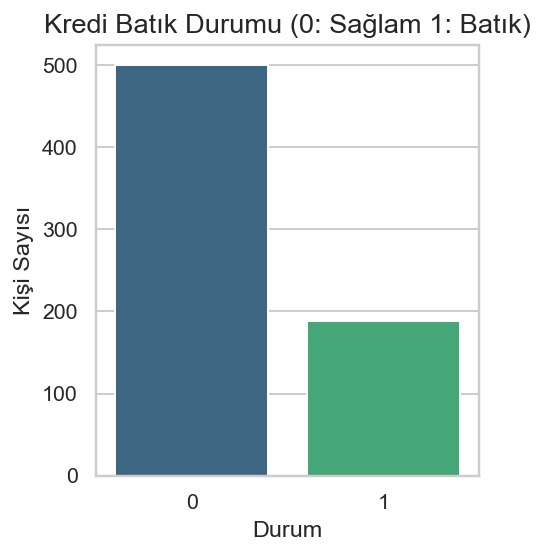

In [78]:
plt.figure(figsize=(12,4),dpi=140)

# Hedef Değişken Dağılımı(Class Balance)
plt.subplot(1, 3, 1)
# 0: Ödeyenler, 1: Batanlar
sns.countplot(x='loan_default', data=df, palette='viridis')
plt.title('Kredi Batık Durumu (0: Sağlam 1: Batık)', fontsize=14)
plt.xlabel('Durum')
plt.ylabel('Kişi Sayısı')
plt.savefig('Kredi_Batik_Durum.png', dpi=300, bbox_inches='tight')
plt.show()

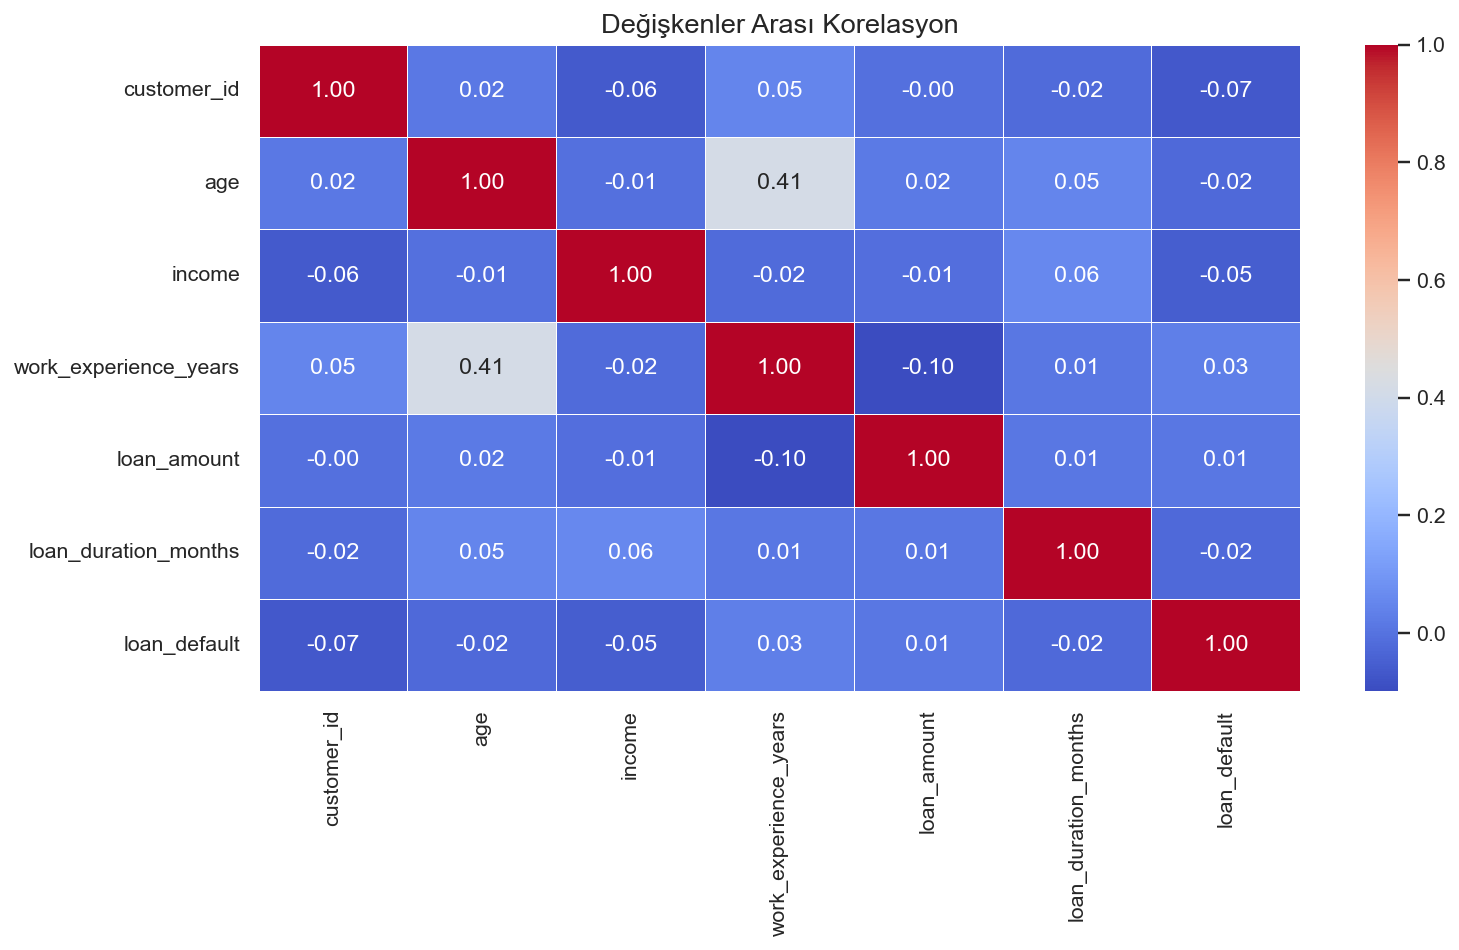

In [41]:
plt.figure(dpi=140,figsize=(12,6))
numeric_df = df.select_dtypes(include=['float64', 'int64', 'int32'])
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Değişkenler Arası Korelasyon', fontsize=14)
plt.savefig('varriables_corr.png', dpi=300, bbox_inches='tight')
plt.show()

In [42]:
df['log_income'] = np.log1p(df['income'])

In [43]:
log_income_safe = df[df['loan_default'] == 0]['log_income'] # Sağlamlar
log_income_risky = df[df['loan_default'] == 1]['log_income'] # Batıklar

In [44]:
print(f" Sağlamlar: {len(log_income_safe)} \n Batıklar: {len(log_income_risky)}")

 Sağlamlar: 500 
 Batıklar: 189


In [45]:
df["log_income"].head()

0    15.424949
1    10.138655
2     9.840430
3    11.007222
4    10.783645
Name: log_income, dtype: float64

In [46]:
print(f"Örneklem Büyüklügü: {len(df)}")  

Örneklem Büyüklügü: 689


In [90]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [61]:
#ENCODING
df_encoded = pd.get_dummies(df, columns=['housing_status', 'employment_type', 'credit_history'], drop_first=True)

In [62]:
if 'customer_id' in df_encoded.columns:
    df_encoded = df_encoded.drop('customer_id', axis=1)  #drop customer_id in dataframe

In [65]:
# BAĞIMLI (Y) ve BAĞIMSIZ (X) 
X = df_encoded.drop('loan_default', axis=1)
y = df_encoded['loan_default']              # (1: Batık 0: Sağlam)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [67]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [68]:
print(f"Eğitim Seti: {X_train_scaled.shape[0]} satır")
print(f"Test Seti  : {X_test_scaled.shape[0]} satır")

Eğitim Seti: 551 satır
Test Seti  : 138 satır


In [89]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [70]:
model = LogisticRegression(class_weight='balanced', random_state=42)

In [71]:
model.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [72]:
y_pred = model.predict(X_test_scaled)

In [74]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Doğruluğu (Accuracy): %{accuracy*100:.2f}")

Model Doğruluğu (Accuracy): %67.39


In [75]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.75      0.77       100
           1       0.42      0.47      0.44        38

    accuracy                           0.67       138
   macro avg       0.60      0.61      0.61       138
weighted avg       0.69      0.67      0.68       138



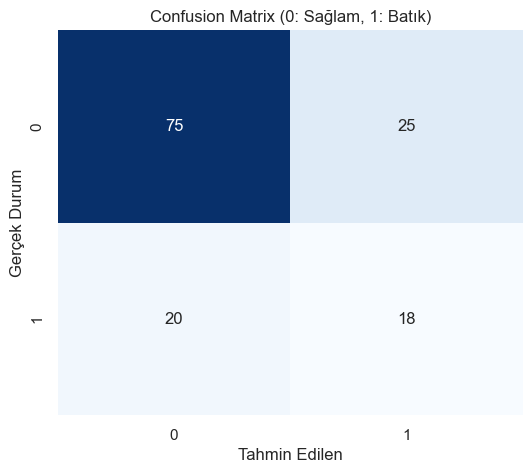

In [77]:
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek Durum')
plt.title('Confusion Matrix (0: Sağlam, 1: Batık)')
plt.show()